# **Chap4：循环神经网络RNN**

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import jieba
from tqdm import tqdm
import time
import numpy as np
from source.code import ch4
from source.code import utils

2023-07-10 11:11:29.743084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 11:11:29.890726: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 11:11:29.922738: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-10 11:11:30.626440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=1)

## **4.4 Tensorflow 高效定义 RNN**

### **4.4.1 `Cell` 封装和更高层级的 API**

在前面章节关于 RNN 的实现中，我们都将计算逻辑拆散为：
* **获取 RNN 参数** `get_params()`
* **RNN 层推理逻辑** `rnn_func()`
* **获取初始状态** `init_state()`

三个部分，然后用我们定义的 `RNNModelScratch` 将它们封装为模型，便于**学习和了解模型的计算逻辑**

在实验时，我们借助Tensorflow提供的高层级 API，然后用我们定义的 `RNNModel` 包装包括**嵌入层，RNN 层和输出层的计算逻辑**，其特点是：
* 这些 RNN **模型的定义都是基于** `Cell` 来定义的，然后通过 `tf.keras.layers.RNN` 包装为 RNN 模块，Tensorflow提供了三种基础 `Cell`
  * `tf.keras.layers.SimpleRNNCell`
  * `tf.keras.layers.GRUCell`
  * `tf.keras.layers.LSTMCell`
* 我们需要**手动管理 RNN 模型中隐藏状态的获取，计算和更新**
* 可以**细致的掌控计算逻辑**，利用 `Cell` 实现模型利于学习，也利于做自定义的扩展

但这种方式定义 RNN 模型也存在缺点：
* **定义过程相对复杂，不够简洁**
  * 例如需要手动控制隐藏状态的获取，更新
  * 例如我们需要对输入文本转置，以改变其形状为 `(num_steps, batch_size)`
* 更重要的是，**用** `Cell` **定义的模型无法使用 GPU 的 CuDNN 加速**，会降低模型性能

在不需要仔细控制模型的计算行为时，Tensorflow提供了更高层级的 RNN 的 API 实现，**它们有更高的计算效率**，并且可以像 CNN 一样更加方便和灵活的作为一个计算层加入到各种模型中，`Tensorflow` 提供以下三个 RNN 模型的层：
* `tf.keras.layers.SimpleRNN` （对应于 `tf.keras.layers.SimpleRNNCell`）
* `tf.keras.layers.GRU` （对应于 `tf.keras.layers.GRUCell`）
* `tf.keras.layers.LSTM` （对应于 `tf.keras.layers.LSTMCell`）

你可以简单理解为，以下方式定义的两个层，在**输入输出的计算逻辑上是等价的**：
```python
# 使用 Cell 定义
num_hiddens = 256
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens)
rnn_layer = tf.keras.layers.RNN(rnn_cell)
```
**对比**
```python
# 直接使用 SimpleRNN
num_hiddens = 256
rnn_layer = tf.keras.layers.SimpleRNN(num_hiddens)
```

**对 GRU 和 LSTM 也是同理**，区别在于后者的实现更加简单，计算效率也更高
* 默认参属下，`SImpleRNN`, `GRU`, `LSTM` 都只会输出**最后一个时间步的隐藏状态** $H$
* 你可以通过**设置** `return_sequence = True` **将每个时间步的隐藏状态输出**，从而基于它们实现多层的深度 RNN 模型
* 假设 `num_steps = T`，我们提供的输入是 $X_1,X_2,\cdots,X_T$，则：
  * `return_sequence = True` 时，模型返回 $H_1,H_2,\cdots,H_{T}$，你可以用它们来构造 $O_1,O_2,\cdots,O_T$，或者**在自回归模型中，可以用它们来预测** $X_2,X_3,\cdots,X_{T+1}$
  * `return_sequence = False` 时，模型只返回 $H_{T}$
* 此外，我们还能像 CNN 那样**将 RNN 模型封装进** `Sequential` **模型**

In [3]:
def create_rnn_model_API(num_hiddens : int, embed_size : int, vocab_size : int):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_size, input_length=5), # 假设序列长度固定为 5
        tf.keras.layers.SimpleRNN(num_hiddens, return_sequences=True),
        tf.keras.layers.Dense(vocab_size),
        tf.keras.layers.Softmax()
    ])
    return model

通过这种方式定义模型的优势还包括：
* 我们再也**无需关心隐藏状态的获取和更新**
* 无需关心 RNN 层的推理过程，你可以**放心把批量维度放在输入的第一个维度**
* 只需要**关注模型整体的计算逻辑，以及你想要获得什么样的输出**

In [4]:
# 创建模型
model = create_rnn_model_API(num_hiddens=256, embed_size=64, vocab_size=28)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 64)             1792      
                                                                 
 simple_rnn (SimpleRNN)      (None, 5, 256)            82176     
                                                                 
 dense (Dense)               (None, 5, 28)             7196      
                                                                 
 softmax (Softmax)           (None, 5, 28)             0         
                                                                 
Total params: 91,164
Trainable params: 91,164
Non-trainable params: 0
_________________________________________________________________


2023-07-10 11:11:41.887505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 11:11:42.668473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30000 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0


In [5]:
# 创建特征
batch_size, num_steps = 4, 5
X = tf.reshape(tf.range(batch_size*num_steps), (batch_size, num_steps))

Y = model(X)
print("输出形状：", Y.shape)

输出形状： (4, 5, 28)


### **4.4.2 性能对比**

我们通过一个实验来对比使用 `Cell` 实现和用 `SimpleRNN` 实现的模型的性能差异

In [6]:
def performance_comparsion(vocab_size : int, embed_size : int, 
                           allow_cudnn : bool=True, num_hiddens : int=256, ):
    # 定义 LSTM 层，对比性能
    if allow_cudnn:
        rnn_layer = tf.keras.layers.LSTM(num_hiddens,return_sequences=True)
    else:
        rnn_layer = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(num_hiddens),return_sequences=True)
    
    # 创建模型
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_size),
        rnn_layer,
        tf.keras.layers.Dense(vocab_size),
        tf.keras.layers.Softmax()
    ])

    return model

我们重新定义一下模型的训练函数，现在他应该更接近我们在学习 CNN 时定义的训练逻辑

In [7]:
def train_text_generation_API(model, train_iter : ch4.SeqDataLoader, 
                              Epochs : int=10, lr : float=0.1, verbose : int=1):
    # 设定优化器和损失函数
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    animator = utils.Animator(xlabel='epoch', ylabel='perplexity', 
                            legend=("perplexity",), xlim=[1, Epochs])
    
    # 存储每个迭代周期的损失和样本量
    loss_batch, samples_batch = 0, 0
    # 记录单词处理速度
    speeds = []

    for epoch in range(Epochs):
        start = time.time()
        # 训练模型
        for x_batch, y_batch in train_iter:
            # x_batch 和 y_batch 形状 : (batch_size, num_steps)
            with tf.GradientTape() as tape:
                y_hat = model(x_batch,training=True) # 形状 : (batch_size, num_steps, vocab_size)
                loss = loss_func(y_batch, y_hat)
            weights = model.trainable_variables
            grads = tape.gradient(loss, weights)
            grads = ch4.grad_clipping(grads, 1)
            optimizer.apply_gradients(zip(grads, weights))

            # 将该批量的损失函数值加到总损失函数值上
            loss_batch += loss.numpy() * tf.size(y_batch).numpy()
            samples_batch += tf.size(y_batch).numpy()
    
        end = time.time()
        speeds.append(samples_batch / (end - start))
    
        if epoch == 0 or (epoch + 1) % verbose == 0:
            # 计算困惑度
            ppl = tf.math.exp(loss_batch / samples_batch).numpy()
            animator.add(epoch + 1, [ppl])

    print(f"平均 {np.mean(speeds):.1f} 词元/秒")
    return model

接下来，导入数据集，开始训练模型，我们对比模型训练的速度

In [10]:
# 导入词表迭代器
train_iter = ch4.SeqDataLoader(
    file="../source/data/text/余华作品集.txt",token="char", concat=True,
    num_lines=50000, batch_size=128, num_steps=32, use_random_iter=True
)
vocab = train_iter.vocab

  0%|          | 0/31692 [00:00<?, ?it/s]

100%|██████████| 31692/31692 [00:00<00:00, 376868.05it/s]


**(1) 使用 `Cell` 定义的模型**

平均 617211.3 词元/秒


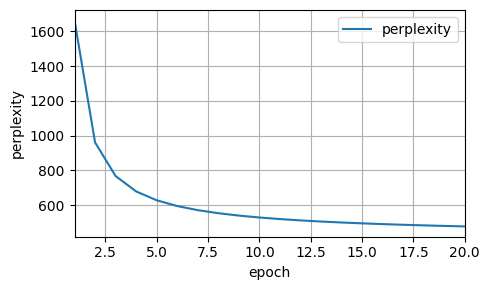

In [193]:
# 实例化模型
model = ch4.performance_comparsion(allow_cudnn=False,num_hiddens=512,vocab_size=len(vocab), embed_size=64)
model = ch4.train_text_generation_API(model,train_iter=train_iter,Epochs=20,verbose=1)

**(2) 使用 CuDNN 加速的模型**

平均 1463768.4 词元/秒


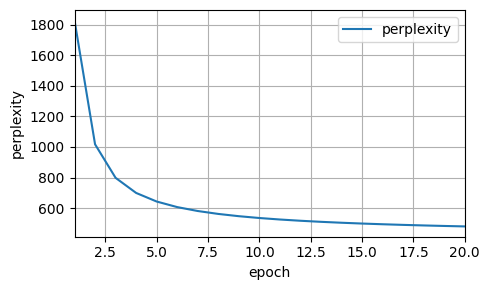

In [11]:
# 实例化模型
model = ch4.performance_comparsion(allow_cudnn=True,num_hiddens=512,vocab_size=len(vocab), embed_size=64)
model = ch4.train_text_generation_API(model,train_iter=train_iter,Epochs=20,verbose=1)

通过实验可以看到，包含一层 LSTM 的网络，**使用 CuDNN 加速高层级 API 可以加速 5 倍**

此外，如果使用了新的接口来定义模型，那么**在文本预测上，也需要稍作调整**，我们重新定义 `chinese_text_predict_API`

In [12]:
def chinese_text_predict_API(prefix, num_preds : int, model, vocab, num_steps : int=None, token : str="char"):
    # 将输入的前缀填充到符合输入要求的长度 num_steps
    def pad(tokens : list):
        if len(tokens) > num_steps:
            return tokens[-num_steps:]
        else:
            while len(tokens) < num_steps:
                # 在开头用 <pad> 填充
                tokens.insert(0, vocab["<pad>"]) 
            return tokens
    
    if token == "word":
        prefix = list(jieba.cut(prefix))
    
    # 转换为词元列表
    prefix_tokens = [vocab[word] for word in prefix]
    # 填充到符合输入要求的长度
    if num_steps is not None:
        prefix_tokens = pad(prefix_tokens)

    outputs = []

    for _ in range(num_preds):
        inputs = tf.reshape(tf.constant(prefix_tokens), (1, -1))
        y_prob = model(inputs,training=False)
        
        # 取出最后一个时间步的输出
        y_hat = tf.argmax(y_prob[0][-1]).numpy()
        word = vocab.to_tokens(y_hat)

        # 添加到输出
        outputs.append(word)
        # 更新 prefix_tokens
        prefix_tokens.append(y_hat) # 添加预测的词元到末尾
        if num_steps is not None:
            # 如果限制了 num_steps，去掉开头的词元，保持序列长度不变
            prefix_tokens = prefix_tokens[1:] 
            
    return prefix + "".join(outputs)

In [13]:
prefix = [
    "今天天气真好，我想",
    "太阳从西边出来了，"
]
for p in prefix:
    print(ch4.chinese_text_predict_API(p, num_preds=10, model=model, vocab=vocab))

今天天气真好，我想，，，，，，，，，，
太阳从西边出来了，，，，，，，，，，，


### **4.4.3 关于使用新接口的补充说明**

最后，我们补充一些在具体使用接口 `SimpleRNN`，`GRU`，`LSTM` 时的注意事项和技巧

**(1) 关于使用双向 RNN**

双向循环神经网络的实现与之前介绍的类似，我们只需要用 `tf.keras.layers.Bidirectional()` 将我们的 RNN 层包装即可
* 此外，`Tensorflow` **允许我们前向，后向使用不同的 RNN 模型**，通过设置 `backward_layer` 参数实现

```python
num_hiddens = 256
layer = tf.keras.layers.Bidirectional(
    tf.keras.layers.SimpleRNN(num_hiddens)
)
```

**(2) 关于使用多层深度 RNN**

RNN 层可以像 CNN 层一样堆叠使用，但需要注意**靠前的层必须返回整个隐藏状态序列**，即设定 `return_sequence = True`
* `Tensorflow` **允许不同的层使用不同的 RNN 模型**，例如将 `SimpleRNN`，`GRU`，`LSTM` 混合使用
* 双向 RNN 可以和多层深度 RNN 结合，**你可以让中间某一层变为双向的**

```python
num_hiddens = 256
# 定义一个三层的循环神经网络
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(num_hiddens, return_sequences=True),
    tf.keras.layers.GRU(num_hiddens, return_sequences=True),
    tf.keras.layers.LSTM(num_hiddens)
])
```

**(3) 关于超参数**

`SimpleRNN`，`GRU` 和 `LSTM` 方法中有很多超参数，由于 **CuDNN 内核是基于某些假设构建的，这意味着如果更改了内置 LSTM 或 GRU 层的默认设置，则该层将无法使用 CuDNN 内核**。例如：
* 将 `activation` 函数从 `tanh` 更改为其他
* 将 `recurrent_activation` 函数从 `sigmoid` 更改为其他
* 使用大于零的 `recurrent_dropout`
* 将 `unroll` 设置为 `True`
* 将 `use_bias` 设置为 `False`

具体更多的说明可以参考：[Tensorflow LSTM说明](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/LSTM)

如果没有按照这些标准设置参数也不必担心，**这只会影响模型的计算性能**，模型依然能够正确给出输出，但还是建议**在没有确认是否要改变这几个参数的前提下，保持默认设置即可**

**(4) 关于状态延续和清除**

在之前的演示中，我们提到过两种批量数据的生成方式：**随机生成策略**和**顺序分区策略**：
* 对于**随机生成策略**，不同批次数据的子序列不连续，因此我们每次会**重置或者重新生成隐藏状态**
* 对于**顺序分区策略**，不同批次数据的子序列在时间步上连续，因此我们希望**隐藏状态在跨批次数据之间延续**，而**不要重置**

在 `SimpleRNN`, `GRU` 和 `LSTM` 接口中，设置参数 `stateful = True` 可以**保留隐状态跨批次传递**，默认情况下 `statefl = False`
* 在此设置中，如果一个批次包含 `[sequence_A_from_t0_to_t100, sequence_B_from_t0_to_t100]`，则下一个批次应该包含 `[sequence_A_from_t101_to_t200, sequence_B_from_t101_to_t200]`，**需要所有批次应该包含相同的样本数量（批次大小）**

```python
# 启用连续分区策略
num_hiddens = 512
layer = tf.keras.layers.LSTM(num_hiddens, stateful=True)
```

而如果设置 `stateful = True` 后，想要重置状态，则可以调用 `layer.reset_states()` 实现

```python
layer.reset_states()
```

----

### **练习**

1. 这个练习将帮助你提升框架的使用，并加深 RNN 模型计算的理解
   1. 借助 `CuDNN` 加速的 RNN 计算曾 （`SimpleRNN`, `GRU`，`LSTM`），继承`tf.keras.model.Model` 搭建一个**两层的 RNN 模型** 实现文本预测，满足如下要求：
      1. 首先对输入序列进行**词嵌入**
      2. 第一个 RNN 层设置 `return_state = True`，以获取隐藏状态 `layer1_state`
      3. 第二个 RNN 层设置 `return_state = True`，以获得隐藏状态 `layer2_state`，同时**第二层 RNN 只返回最后时间步的输出**
      4. 设计模型的输出层，使我们能获得输出词元的概率分布
      5. 模型推理`call()`返回两个元素，第一个元素是输出词元概率分布 `y_hat`，第二个元素是存储隐藏状态的列表 `[layer1_state, layer2_state]`
   2. 思考给定输入 $X\in\mathbb{R}^{n\times T}$，$m,T$ 分别表示批量大小和时间步，这时候**模型的输出** `y_hat` 形状是什么？
   3. 在我们之前的实现中，每个批量数据 `x_batch, y_batch` 的形状都是 `(batch_size, num_steps)`，这时候很显然**我们不能直接用** `y_batch` **和模型的输出** `y_hat` **计算损失**
      1. 解释为什么不能直接计算损失了
      2. **修改训练函数有关损失的计算**，使其能够在这种情况下正常工作
      3. 如果不修改训练函数，我们还可以从训练数据 `x_batch, y_batch` 的生成上调整，简述这时候的数据生成逻辑

----